# High-Fidelity Orbit Propagator

The orbital prediction code is developed based on Cowell's formulation, considering perturbating effects to enhance accuracy. The predictions acknowledge several crucial factors that influence a satellite's orbit, including the Earth's oblateness, atmospheric drag, solar radiation pressure, third-body perturbations (Moon, Sun), Earth Albedo radiation, tides, variations in Earth's magnetic field, and thrust misalignment. These factors, if not considered, can lead to cumulative errors over time. The code particularly focuses on Low Earth Orbits (LEO), where zonal harmonics J2, atmospheric drag, and third-body perturbations play a predominant role. For polar or sun-synchronous orbits, zonal harmonics J3, J4, J5 also exert a significant influence.

Cowell's formulation is chosen for its accuracy and computational efficiency in addressing these perturbations within the two-body problem. The formulation incorporates additional parameters, such as the satellite's ballistic coefficient, determined by mass, area, and atmospheric density, crucial for precision in orbit predictions. Emphasizing the importance of accurate initial Keplerian elements, the code ensures that deviations from these elements are minimized to maintain prediction accuracy. This high-fidelity modeling approach aims to provide precise and reliable predictions by accounting for a comprehensive set of perturbing effects in the satellite's orbital dynamics.

Estimation of Sun vector is based on first principles[1], while estimation of moon is done using `spicypy` library. Atmospheric density is modelled using `pynrlmsise00`.

**Input:**
Classical Orbital Elements

**Output:**
Propagated Orbit using high-fidelity model and error plot between high-fidelity propagated orbit and basic gravity model propagated orbit with ISS OEM File available in Public domain

By, Mayur Vijay Pawar

In [ ]:
# Install SPICYPY & NRLMSISE Libraries to Estimate Perturbating Objects
!rm -rf pynrlmsise00
!pip install nrlmsise00

import nrlmsise00
from datetime import datetime
from nrlmsise00 import msise_model

!pip install spiceypy
import spiceypy as spice

# Import Python Libraries
import numpy as np
import math as m
from sympy import symbols, solve
from matplotlib import pyplot as plt

# Mount Google Drive to access de340.bsp and naif0012 files
from google.colab import drive
drive.mount('/content/drive')

# Specify the paths to the SPICE kernels in Google Drive
de430_path = '/content/drive/MyDrive/Study/de430.bsp'
leapseconds_path = '/content/drive/MyDrive/Study/naif0012.tls.txt'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.5/86.5 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.8 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
# Define Constants
mu = 398600.44        # km^3 s^-2
mu_L = 4903           # km^3 s^-2
mu_S = 132712000000   # km^3 s^-2
Re = 6378             # km
J2 = 0.0010827
J3 = -2.532 * 10**(-6)
J4 = -1.619331214*10**(-6)
J5 = -2.2729608287*10**(-7)

In [ ]:
'''
Function to convert UTC time to Julian Date needed to run the integrator function
and facilitate further time convertions within Orbit propagator to access libraries
'''
def UTC2JD(yr, mo, dy, hr, min, sec):
  a = 367 * yr
  b = int((7 * (yr + int((mo + 9) / 12))) / 4)
  c = int((275 * mo) / 9)
  d = dy
  e = 1721013.5
  f = (( sec / 60 + min) / 60 + hr) / 24
  JD = a - b + c + d + e + f

  return JD

In [ ]:
# Function to convert Julian date to Gregorian date to access NRLMSISE00
def JD2UTC(t):
    # Calculate the Julian day number (JDN)
    jdn = t + 0.5

    # Convert Julian day number to Gregorian date
    a = int(jdn) + 32044
    b = (4 * a + 3) // 146097
    c = a - (146097 * b) // 4
    d = (4 * c + 3) // 1461
    e = c - (1461 * d) // 4
    m = (5 * e + 2) // 153

    day = e - ((153 * m + 2) // 5) + 1
    month = m + 3 - 12 * (m // 10)
    year = 100 * b + d - 4800 + (m // 10)

    # Calculate the fractional part of the day
    frac_day = jdn - int(jdn)

    # Convert fractional day to hours, minutes, and seconds
    total_seconds = int(frac_day * 86400)
    hours, remainder = divmod(total_seconds, 3600)
    minutes, seconds = divmod(remainder, 60)

    # Create a datetime object for the Gregorian date and time
    GregDate = np.array([year, month, day, hours, minutes, seconds])

    return GregDate

In [ ]:
from math import sqrt, atan2, asin, degrees

# Function to convert ECI Position vector into geodetic coordinates to access NRLMSISE00
def cart2geo(r):
    # Calculate magnitude of position vector
    r_mag = np.linalg.norm(r)

    # Calculate longitude (lambda) and latitude (phi)
    longitude = degrees(atan2(r[1], r[0]))
    lat = degrees(asin(r[2] / r_mag))

    # Calculate altitude
    alt = r_mag - Re

    LLA = np.array([longitude, lat, alt])

    return LLA

In [ ]:
# Input Initial Classical Elements for ISS
a = 6794.849126011357                        # Semi-major axis in km
e =  0.0006221930416567214                   # Eccentricity
i = m.radians(51.75133729827277)             # Inclination in rad
RAAN = m.radians(125.31958765228417)         # Right Ascension of Ascending Node in rad
ArgP = m.radians(82.8460186107099)           # Argument of Perigee in rad
theta = m.radians(136.4462497752546)         # True Anomaly in rad

# Function to Convert Classical Orbital Elements in ECI Position and Velocity Vector
def Kep2Pos(a, e, i, RAAN, ArgP, theta):
  # Calculating Apogee and Perigee
  r1, r2 = symbols('r1 r2')
  eq1 = r1 + r2 - 2 * a
  eq2 = r1 - r2 - 2 * a * e
  r = solve([eq1, eq2], [r1, r2])
  ra = r[r1]
  rp = r[r2]

  # Calculating Specific Angular Momentum and Time for Orbit
  h = m.sqrt(mu * a * (1 - e**2))

  # Converting Classical Elements in Perifocal Reference Frame
  r_xbar = [((h**2 / mu) * (1 / (1 + e * m.cos((theta))))) * m.cos((theta)), ((h**2 / mu) * (1 / (1 + e * m.cos((theta))))) * m.sin((theta)), 0]
  v_xbar = (mu / h) * np.array([-m.sin(theta), e + m.cos(theta), 0])

  # Generating Orthogonal Transformation Matrix to convert Perifocal Reference frame to ECI frame
  Q = np.array ([
      [-1 * m.sin(RAAN) * m.cos(i) * m.sin(ArgP) + m.cos(RAAN) * m.cos(ArgP),
      m.cos(RAAN) * m.cos(i) * m.sin(ArgP) + m.sin(RAAN) * m.cos(ArgP),
      m.sin(i) * m.sin(ArgP)],
      [-1 * m.sin(RAAN) * m.cos(i) * m.cos(ArgP) - m.cos(RAAN) * m.sin(ArgP),
      m.cos(RAAN) * m.cos(i) * m.cos(ArgP) - m.sin(RAAN) * m.sin(ArgP),
      m.sin(i) * m.cos(ArgP)],
      [m.sin(RAAN) * m.sin(i), -1* m.cos(RAAN) * m.sin(i), m.cos(i)]
  ])

  # Taking Transpose of Transformation Matrix
  Qt = Q.T

  # Calculating Position and Velocity vector in ECI frame
  r = Qt @ r_xbar
  v = Qt @ v_xbar
  ECI = np.array([r[0], r[1], r[2], v[0], v[1], v[2]])
  return np.array(ECI)

# Converting Classical Orbital Elements of ISS in ECI Position and Velocity Vector
ECI_A = Kep2Pos(a, e, i, RAAN, ArgP, theta)
r = np.array([ECI_A[0], ECI_A[1], ECI_A[2]])  # km
v = np.array([ECI_A[3], ECI_A[4], ECI_A[5]]) # km/sec

# Initial Conditions
y0 = np.array([r[0], r[1], r[2], v[0], v[1], v[2]])

# Declaring Time Steps and setting time vector for simulation
dt = 10                                            # Time step in sec
t0 = UTC2JD(2023, 12, 20, 12, 0, 0) * 24 * 60 * 60 # Initial date and time in Gregorian Date format
T = 1                                              # Simulation days
tn = t0 + (T * 24 * 60 * 60)                       # Final date and time in Julian Date format
num_time_pts = int((tn - t0) / dt)                 # Number of time steps
t = np.linspace(t0, tn, num_time_pts)              # Time vector in Julian Date format

In [ ]:
# Function of RK4 Numerical Integrator
def rk4(f, dt, t0, y0):
  f1 = f(t0, y0)
  f2 = f(t0 + dt / 2, y0 + (dt / 2) * f1)
  f3 = f(t0 + dt / 2, y0 + (dt / 2) * f2)
  f4 = f(t0 + dt, y0 + dt * f3)

  yout = y0 + (dt / 6) * (f1 + 2 * f2 + 2 * f3 + f4)
  return yout

In [ ]:
'''
Function of Orbit Propagator with J2, J3, J4, J5, Sun, Moon and Atmospheric
Drag Perturbation effects in account
'''
def orbit(t, y):
  # Converting Julian Date in seconds to Days to Facilitate estimation of Sun vector
  t = t / (24 * 60 * 60)

  '''
  Perturbation effect of Thrid body: Sun
  '''
  # Estimating Sun Vector using First principle[1]
  n = t - 2451545
  M = (357.529 + 0.98560023 * n) % 360
  L = (280.459 + 0.98564736 * n) % 360
  lamda = L + 1.915 * m.sin(m.radians(M)) + 0.02 * m.sin(m.radians(2 * M))
  eu = (23.439 - 3.56 * 10**(-7) * n) % 360
  u_cap = ([m.cos(m.radians(lamda)), m.sin(m.radians(lamda)) * m.cos(m.radians(eu)), m.sin(m.radians(lamda)) * m.sin(m.radians(eu))])
  r_S = 149597870.691 * (1.00014 - 0.0167 * m.cos(m.radians(M)) - 0.00014 * m.cos(m.radians(2 * M)))
  rS = np.multiply(r_S, u_cap)                  # Sun Vector with respect to ECI
  rS_v = m.sqrt(rS[0]**2 + rS[1]**2 + rS[2]**2) # Magnitude of Sun Vector
  r_ss = np.array([rS[0] - y[0], rS[1] - y[1], rS[2] - y[2]])
  r_ss_v = m.sqrt((r_ss[0]**2) + (r_ss[1]**2) + (r_ss[2]**2))

  # Calculating difference between nearly equal numbers
  q = y[0:3] * (2 * rS - y[0:3]) / (rS_v**2)
  Fq = q * (q**2  - 3 * q + 3) / (1 + (1 - q)**(3/2))
  # Perturbating Acceleration due to Sun
  a_Sun = mu_S * (Fq * rS - y[0:3]) / (r_ss_v**3)

  '''
  Perturbation effect of Atmospheric Drag
  '''
  # Estimating Atmosperic Drag Perturbation Term
  Bstar = 36106e-3 # Ballistic Coefficient value of ISS from TLE [2]

  #Converting Julian Date in Gregorian Date to access NRLMSISE00
  GD = JD2UTC(t)

  # Converting ECI position vector to geodetic coordinate to access NRLMSISE00
  LLA = cart2geo(y)

  # Accessing NRLMSISE00 to get value air density locally at the perticular time and position
  output = msise_model(datetime(GD[0], GD[1], GD[2], GD[3], GD[4], GD[5]), LLA[2], LLA[0], LLA[1], 150, 150, 4, lst=16)
  output_list = output[0]

  # Extract the value of air density from the first list
  rho = output_list[5] * 1000

  # Magnitude of velocity vector
  v_mag = np.sqrt((y[3])**2 + (y[4])**2 + (y[5])**2)

  # Perturbating Acceleration due to Atmosphric Drag
  a_atm = [- 0.5 * rho * v_mag * Bstar * y[3], - 0.5 * rho * v_mag * Bstar * y[4], - 0.5 * rho * v_mag * Bstar * y[5]]

  '''
  Perturbation effect of Third body: Moon
  '''
  # Formating Gregorian Date string to further processed by SPICE Kernals
  formatted_string = f"{GD[0]}-{GD[1]:02d}-{GD[2]:02d}T{GD[3]:02d}:{GD[4]:02d}:{GD[5]:02d}"

  # Load the SPICE kernels
  spice.furnsh(de430_path)
  spice.furnsh(leapseconds_path)

  t = spice.str2et(formatted_string)

  # Estimating Position of Moon using SPICE Kernals
  rM_tuple = spice.spkpos('MOON', t, 'J2000', 'NONE', 'EARTH')[:]
  rM = np.array(rM_tuple[0])  # Extracting the position vector of MOON
  rM_v = m.sqrt(rM[0]**2 + rM[1]**2 + rM[2]**2)

  # Unload the SPICE kernels
  spice.unload(de430_path)
  spice.unload(leapseconds_path)

  r_ms = np.array([rM[0] - y[0], rM[1] - y[1], rM[2] - y[2]])
  r_ms_v = m.sqrt((r_ms[0]**2) + (r_ms[1]**2) + (r_ms[2]**2))
  # Perturbating Acceleration due to Moon
  a_Lunar = mu_L * ((r_ms / (r_ms_v**3)) - (rM / (rM**3)))

  '''
  Perturbation of effect of Zonal Harmonics J2, J3, J4 & J5
  '''
  # Implimenting zonal harmonics perturbating acceleration by J2, J3, J4
  r = m.sqrt((y[0])**2 + (y[1])**2 + (y[2])**2)
  a_sphJ2 = [(3 / 2) * ((J2 * mu * Re**2) / r**4) * (y[0] / r) * (5 * (y[2]**2 / r**2) - 1), (3 / 2) * ((J2 * mu * Re**2) / r**4) * (y[1] / r) * (5 * (y[2]**2 / r**2) - 1), (3 / 2) * ((J2 * mu * Re**2) / r**4) * (y[2] / r) * (5 * (y[2]**2 / r**2) - 3)]
  a_sphJ3 = [((-1 * 5 * J3 * mu * Re**3 * y[0]) / (2 * r**7)) * (3 * y[2] - ((7 * y[2]**3) / r**2)), ((-1 * 5 * J3 * mu * Re**3 * y[1]) / (2 * r**7)) * (3 * y[2] - ((7 * y[2]**3) / r**2)), ((-1 * 5 * J3 * mu * Re**3) / (2 * r**7)) * (3 * y[2]**2 - ((7 * y[2]**4 / r**2) - (3 / 5) * r**2))]
  a_sphJ4 = [((15 * J4 * mu * Re**4 * y[0]) / (8 * r**7)) * (1 - ((14 * y[2]**2) / r**2) + (21 * y[2]**4 / r**4)), ((15 * J4 * mu * Re**4 * y[1]) / (8 * r**7)) * (1 - ((14 * y[2]**2) / r**2) + (21 * y[2]**4 / r**4)), ((15 * J4 * mu * Re**4 * y[2]) / (8 * r**7)) * (5 - ((70 * y[2]**2) / (3 * r**2)) + (21 * y[2]**4 / r**4))]
  # J5 perturbating term
  term1 = 3 * J5 * mu * Re**5 / (8 * r**9)
  term2 = 35 - 210 * (y[2]**2 / r**2) + 231 * (y[2]**4 / r**4)
  a_IJ5 = term1 * y[0] * y[2] * term2
  a_JJ5 = term1 * y[1] * y[2] * term2
  a_KJ5 = term1 * y[2]**2 * (105 - 315 * (y[2]**2 / r**2) + 231 * (y[2]**4 / r**4)) - 15 * J5 * mu * Re**5 / (8 * r**7)
  a_sphJ5 = [a_IJ5, a_JJ5, a_KJ5]

  # Combined Acceleration Function given Cowell's Formulations [3]
  a = -1 * (mu / r**3) * y[0:3] + a_sphJ2 + a_sphJ3 + a_sphJ4 + a_sphJ5 + a_atm + a_Sun #+ a_Lunar

  # Converting Gregorian Date to Julian Date in seconds to facilitate numerical integration
  t = UTC2JD(GD[0], GD[1], GD[2], GD[3], GD[4], GD[5]) * 24 * 60 * 60

  # Output array
  dy = [y[3], y[4], y[5], a[0], a[1], a[2]]
  return np.array(dy)

In [ ]:
# Setting and Solving the RK4 Integrator
Y = np.zeros((6, num_time_pts))
Y[:, 0] = y0
yin = y0

for i in range(num_time_pts - 1):
  yout = rk4(orbit, dt, t[1], yin)
  #print(i)                                # To know the progress of simution
  Y[:, i+1] = yout
  yin = yout

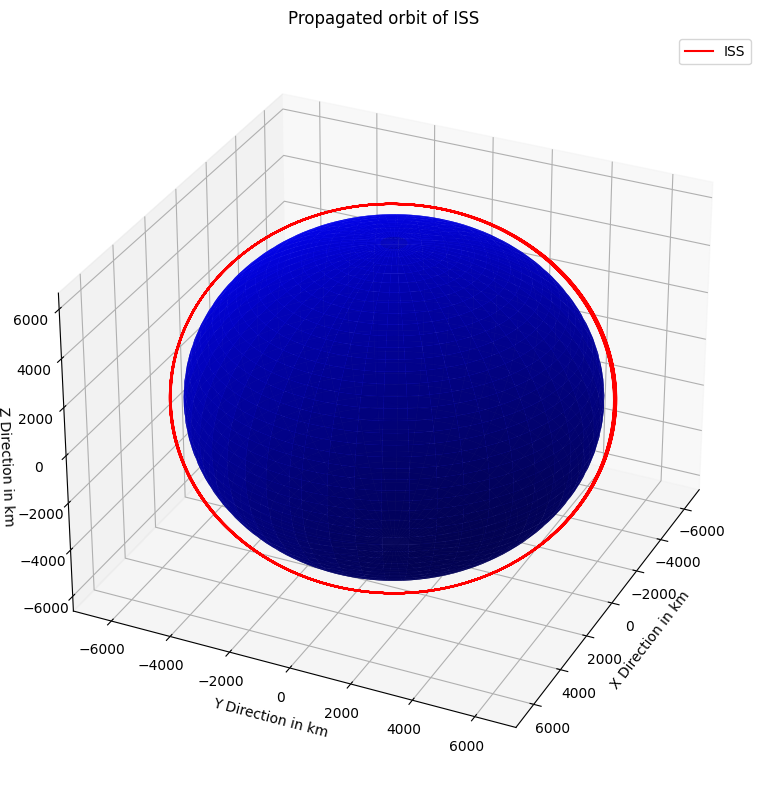

In [ ]:
# Function to create a sphere
def plot_sphere(ax, radius, color):
    phi, theta = np.mgrid[0.0:2.0*np.pi:100j, 0.0:np.pi:50j]
    x = radius*np.sin(theta)*np.cos(phi)
    y = radius*np.sin(theta)*np.sin(phi)
    z = radius*np.cos(theta)
    ax.plot_surface(x, y, z, color=color, alpha=0.9)

# 3D Plots with Earth
fig = plt.figure(figsize=(10, 8))  # Adjust the figure size here
ax = fig.add_subplot(111, projection='3d')
ax.plot(Y[0, :], Y[1, :], Y[2, :], label='ISS', color='Red')
earth_radius = 6378  # Earth's radius in kilometers
plot_sphere(ax, earth_radius, color='blue')

# Additional settings for better visualization
ax.set_xlabel('X Direction in km')
ax.set_ylabel('Y Direction in km')
ax.set_zlabel('Z Direction in km')
ax.set_title("Propagated orbit of ISS")
ax.legend()
ax.view_init(30, 25)
plt.tight_layout()
plt.show()

In [ ]:
# Importing ISS OEM File from publicaly available data to compare accuracy of Orbit Propagator
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt


# Mount your Google Drive (if the file is in Drive)
from google.colab import drive
drive.mount('/content/drive')

# Specify the path to your OEM file (replace with your actual path)
file_path = "/content/drive/MyDrive/Study/ISS_OEM_J2K_EPH.txt"  # For files in Drive
# file_path = "/content/your_oem_file.txt"  # For files uploaded directly to Colab

# Input start and end dates and times
start_date = "2023-12-20"
start_time = "12:00:00.000"
end_date = "2023-12-21"
end_time = "11:56:00.000"

# Read the data into a DataFrame
df = pd.read_csv(file_path, sep=" ", header=None)

# Filter data based on start and end times
df_filtered = df.loc[(df[0] >= start_date + "T" + start_time) & (df[0] <= end_date + "T" + end_time)]

# Extract position vectors into separate variables
positions_x = df_filtered[1].to_numpy()  # Extract column 1 (position X)
positions_y = df_filtered[2].to_numpy()  # Extract column 2 (position Y)
positions_z = df_filtered[3].to_numpy()  # Extract column 3 (position Z)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Reshaping the output matrices to match OEM file shape
from decimal import Decimal, getcontext
getcontext().prec = 8

# Combining OEM File position vectors
positions = np.stack((positions_x, positions_y, positions_z))

n = Y[:, ::24]
t_new = t[::24]

# Generating Error term between OEM file and Orbit Propagator
error_x = positions[0,:] - n[0,:]
error_y = positions[1,:] - n[1,:]
error_z = positions[2,:] - n[2,:]

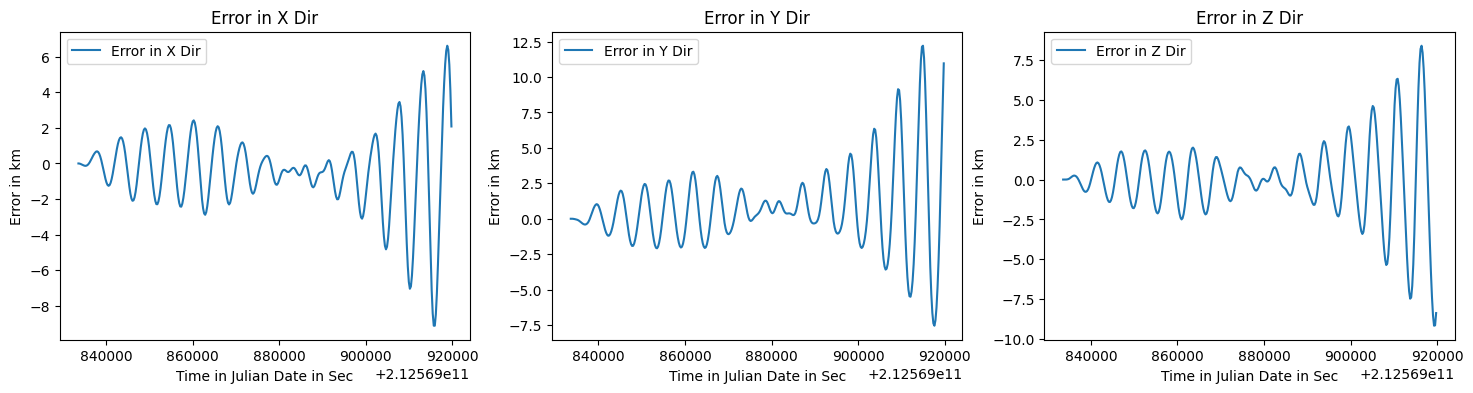

In [ ]:
# Error Plots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))
# Plot the first subplot
ax1.plot(t_new, error_x, label='Error in X Dir')
ax1.set_xlabel('Time in Julian Date in Sec')
ax1.set_ylabel('Error in km')
ax1.set_title('Error in X Dir')
ax1.legend()

# Plot the second subplot
ax2.plot(t_new, error_y, label='Error in Y Dir')
ax2.set_xlabel('Time in Julian Date in Sec')
ax2.set_ylabel('Error in km')
ax2.set_title('Error in Y Dir')
ax2.legend()

# Plot the third subplot
ax3.plot(t_new, error_z, label='Error in Z Dir')
ax3.set_xlabel('Time in Julian Date in Sec')
ax3.set_ylabel('Error in km')
ax3.set_title('Error in Z Dir')
ax3.legend()

In [ ]:
# Function of Orbit Propagator with only Gravitational Acceleration term without any perturbating effects
def orbitNewton(t, z):
  r = np.sqrt((z[0])**2 + (z[1])**2 + (z[2])**2)
  dy = [z[3], z[4], z[5],
      -1 * (mu / (r**3)) * z[0], -1 * (mu / (r**3)) * z[1], -1 * (mu / (r**3)) * z[2]
  ]
  return np.array(dy)

# Initial Conditions
z0 = np.array([r[0], r[1], r[2], v[0], v[1], v[2]])

# Solving the Integrator
Z = np.zeros((6, num_time_pts))
Z[:, 0] = z0
zin = z0

for j in range(num_time_pts - 1):
  zout = rk4(orbitNewton, dt, t[1], zin)
  Z[:, i+1] = zout
  zin = zout

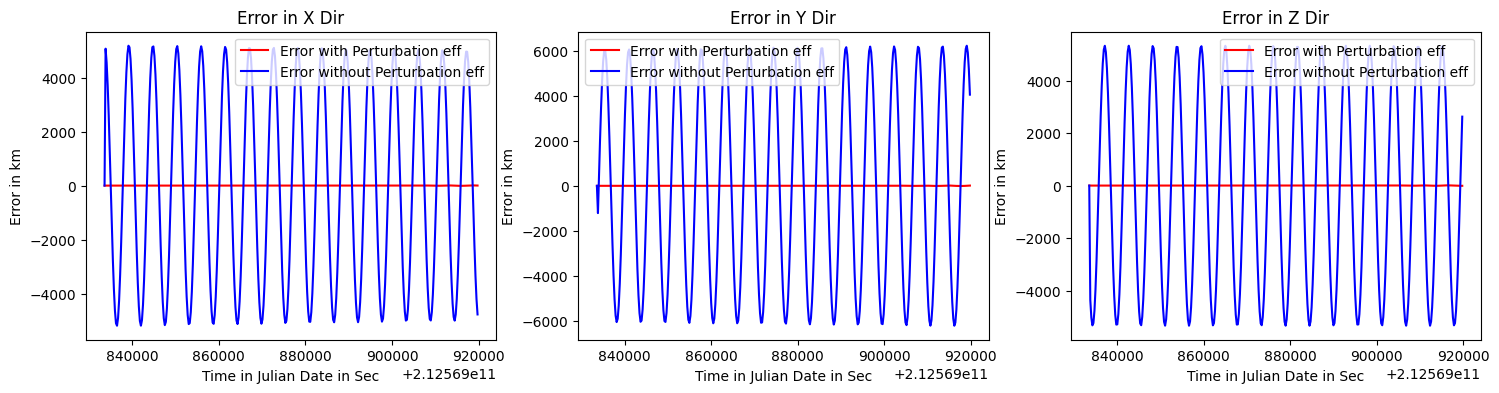

In [ ]:
# Reshaping the output matrices to match OEM file shape
m = Z[:, ::24]

# Generating Error term between OEM file and Orbit Propagator (No perturbation effects)
Nerror_x = positions[0,:] - m[0,:]
Nerror_y = positions[1,:] - m[1,:]
Nerror_z = positions[2,:] - m[2,:]

# Error Plots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))

# Plot the first subplot
ax1.plot(t_new, error_x, label='Error with Perturbation eff', color = 'red')
ax1.plot(t_new, Nerror_x, label='Error without Perturbation eff', color = 'blue')
ax1.set_xlabel('Time in Julian Date in Sec')
ax1.set_ylabel('Error in km')
ax1.set_title('Error in X Dir')
ax1.legend()

# Plot the second subplot
ax2.plot(t_new, error_y, label='Error with Perturbation eff', color = 'red')
ax2.plot(t_new, Nerror_y, label='Error without Perturbation eff', color = 'blue')
ax2.set_xlabel('Time in Julian Date in Sec')
ax2.set_ylabel('Error in km')
ax2.set_title('Error in Y Dir')
ax2.legend()

# Plot the third subplot
ax3.plot(t_new, error_z, label='Error with Perturbation eff', color = 'red')
ax3.plot(t_new, Nerror_z, label='Error without Perturbation eff', color = 'blue')
ax3.set_xlabel('Time in Julian Date in Sec')
ax3.set_ylabel('Error in km')
ax3.set_title('Error in Z Dir')
ax3.legend()

**Reference:**

[1]  Curtis, Howard. Orbital Mechanics for Engineering Students, 3rd ed. Waltham, MA: Elsevier Ltd, 2014.

[2] ARISS. Latest Space-Track ISS TLE. Amateur Radio on the International Space Station. https://live.ariss.org/tle/

[3]  Vallado, David. Fundamentals of Astrodynamics and Applications, 4th ed. Hawthorne, CA: Microcosm Press, 2013.

<ipython-input-64-0d6eb2cb448c>:37: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  satellite_point.set_data(Y[0, :][frame_num], Y[1, :][frame_num])


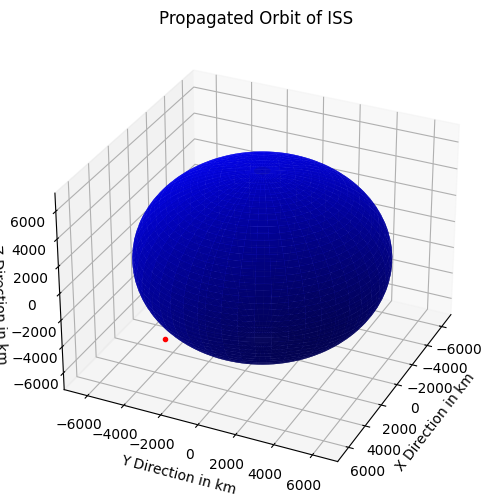

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D, art3d

# Create the figure and 3D axes
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Set labels and title
ax.set_xlabel('X Direction in km')
ax.set_ylabel('Y Direction in km')
ax.set_zlabel('Z Direction in km')
ax.set_title("Propagated Orbit of ISS")
ax.set_xlim((-7000, 7000))
ax.set_ylim((-7000, 7000))
ax.set_zlim((-7000, 7000))
ax.view_init(30, 25)

plot_sphere(ax, earth_radius, color='blue')

# Create separate plot elements for the satellite point and path line
satellite_point, = ax.plot([], [], [], 'ro', markersize=3)  # Red sphere marker for satellite
path_line, = ax.plot([], [], [], 'r-')  # Blue line for path

# Set initial z-coordinate for both point and line
satellite_point.set_3d_properties(Y[2, :][0])
path_line.set_3d_properties(Y[2, :][0])

# Function to update the plot in each frame
def animate(frame_num):
    # Update path line with all data points up to the current frame
    path_line.set_data(Y[0, :][:frame_num + 1], Y[1, :][:frame_num + 1])
    path_line.set_3d_properties(Y[2, :][:frame_num + 1])

    # Update satellite point with only the current position
    satellite_point.set_data(Y[0, :][frame_num], Y[1, :][frame_num])
    satellite_point.set_3d_properties(Y[2, :][frame_num])

    return path_line, satellite_point

# Create the animation
ani = FuncAnimation(
    fig, animate, interval=50, frames=1000,  # Animate the first 1000 time steps
    blit=True
)
plt.show()

In [ ]:
# Display the animation in Colab
from IPython.display import HTML
HTML(ani.to_html5_video())

<ipython-input-64-0d6eb2cb448c>:37: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  satellite_point.set_data(Y[0, :][frame_num], Y[1, :][frame_num])
